In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from mpl_toolkits.mplot3d import Axes3D
import pylab
import plotly.offline as py
import plotly.graph_objs as go
import colorsys
from sklearn.model_selection import train_test_split
%matplotlib inline

from utils import *

# Loading SAR data and apply augmentation

In [2]:
train = pd.read_json('input/train.json', orient='records')
train.inc_angle = train.inc_angle.replace('na',0)
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [3]:
# get pseudo color composite
rgb_train, hsv_train = RGB_HSV_composite(train)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

In [4]:
new_X, new_angle, new_y = simple_augmentation(hsv_train, X_angle_train, y_train, 0.3 )
print(new_X.shape, new_angle.shape, new_y.shape)

(2084, 75, 75, 3) (2084, 1) (2084, 1)


# Data Visualization & EDA

In [5]:
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [6]:
# another way to visualiza band_1
plotmy3d(rgb_train[12,:,:,0], 'iceberg')

Looking at random ships


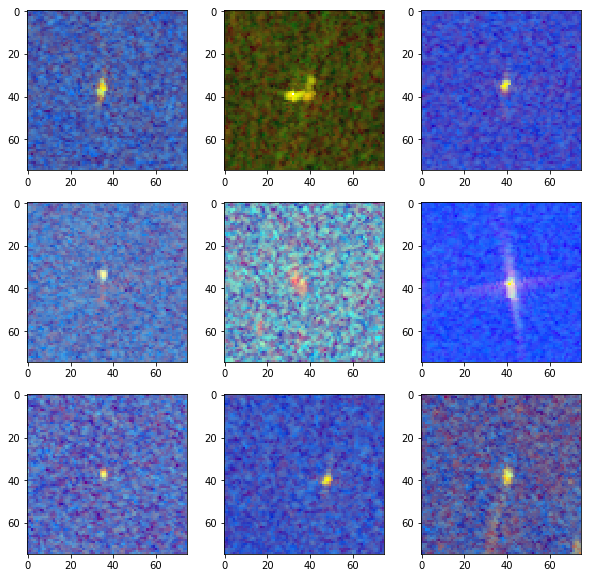

In [7]:
# look at random ships
print('Looking at random ships')
ships = np.where(train.is_iceberg ==0)[0]
ships_rand = np.random.choice(ships,9)
fig = plt.figure(1,figsize=(10,10))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[ships[i], :, :]
    ax.imshow(arr)   
plt.show()

Looking at random iceberg


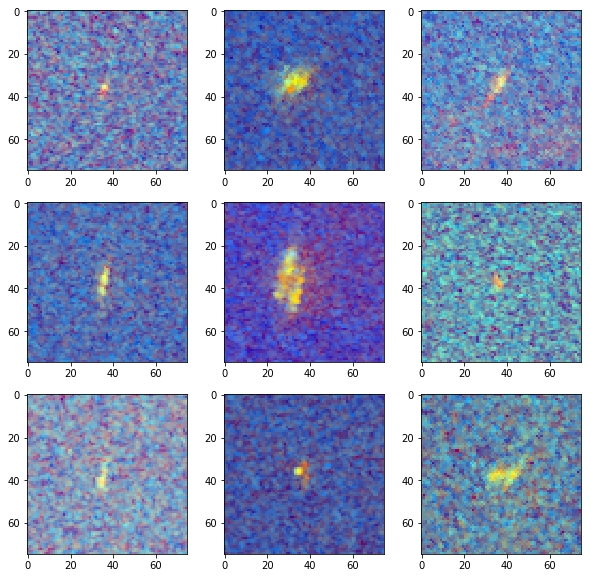

In [8]:
# look at random icebergs
print('Looking at random iceberg')
icebergs = np.where(train.is_iceberg ==1)[0]
icebergs_rand = np.random.choice(icebergs, 9)
fig = plt.figure(1,figsize=(10,10))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[icebergs[i], :, :]
    ax.imshow(arr)   
plt.show()

# Speckle filtering on HSV color space

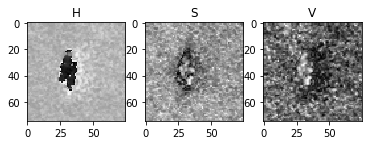

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.imshow(hsv_train[12,:,:,0],cmap = 'gray')
ax2.imshow(hsv_train[12,:,:,1],cmap = 'gray')
ax3.imshow(hsv_train[12,:,:,2],cmap = 'gray')
ax1.set_title('H')
ax2.set_title('S')
ax3.set_title('V')
plt.show()

## Filter images

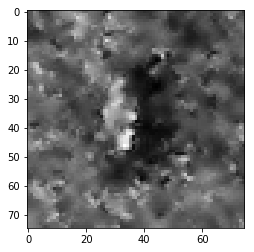

In [10]:
plt.imshow(lee_filter(hsv_train[12,:,:,2], 5), cmap='gray')

In [13]:
HSV_train_filtered = np.zeros_like(hsv_train)
print(np.shape(hsv_train)[0])
for i in range(np.shape(hsv_train)[0]):
    HSV_train_filtered[i,:,:,0] = hsv_train[i,:,:,0]
    HSV_train_filtered[i,:,:,1] = hsv_train[i,:,:,1]
    HSV_train_filtered[i,:,:,2] = lee_filter(hsv_train[i,:,:,2], 5)
    
#RGB_train_filtered = HSV_to_RGB(HSV_train_filtered)

1604


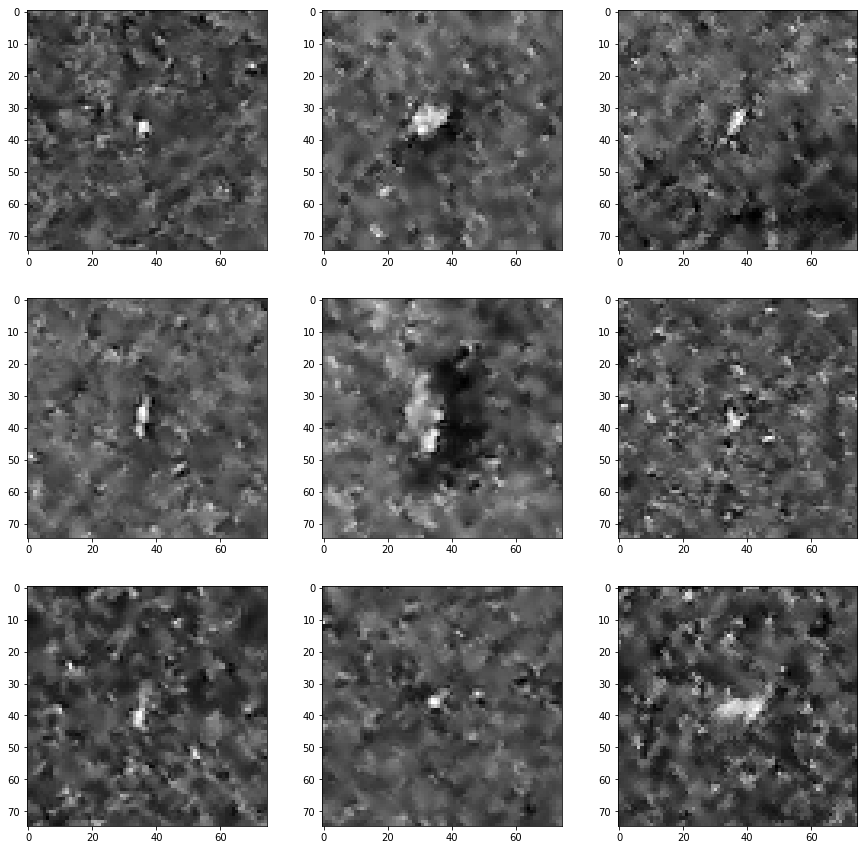

In [15]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = HSV_train_filtered[icebergs[i], :, :, 2]
    ax.imshow(arr, cmap='gray')   
plt.show()

## Save the augmented data

In [16]:
df_train = pd.DataFrame(data = flatten_img(new_X, new_y, new_angle, size = [75,75]),\
                        columns = ['H','S','V','is_iceberg','angle'] )
df_train.to_pickle('output/df_hsv_angmented.pickle')